# Energy Volume Curve Agent
Based on the previous tutorial, the next step is to extend the simple crystal structure agent to address the benchmark challenge of calculating an energy-versus-volume curve using the EMT simulation code. Again, this demonstration is based on the Langchain tutorial for [custom agents](https://python.langchain.com/docs/how_to/custom_tools/).

As a first step, we import a number of python modules, these consist of the [ASE](https://wiki.fysik.dtu.dk/ase/), some standard python libraries as well as a number of tools from [langchain](https://www.langchain.com):

In [1]:
from ase.atoms import Atoms
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.constraints import UnitCellFilter
from ase.eos import calculate_eos, plot
from ase.optimize import LBFGS

In [2]:
from getpass import getpass
from typing import List

In [3]:
from langchain_core.tools import tool
from langchain.agents import AgentExecutor
from langchain.agents.format_scratchpad.openai_tools import format_to_openai_tool_messages
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq

## Multiple Functions
To connect multiple python functions, it is essential to convert all inputs and outputs to `JSON` compatible data types as the communication to the LLM in the background happens in terms of web requests using the `JSON` format. This especially applies to python functions which return python objects. In the case of [ASE](https://wiki.fysik.dtu.dk/ase/) a typical python object is the `ase.atoms.Atoms()` object. To convert the `Atoms()` object to JSON format, we use a [pydantic](https://pydantic.dev) data class as suggested by [langchain](https://www.langchain.com):

In [4]:
class AtomsDict(BaseModel):
    numbers: List[int]
    positions: List[List[float]]
    cell: List[List[float]]
    pbc: List[bool]

AtomsDict.schema()

{'title': 'AtomsDict',
 'type': 'object',
 'properties': {'numbers': {'title': 'Numbers',
   'type': 'array',
   'items': {'type': 'integer'}},
  'positions': {'title': 'Positions',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'cell': {'title': 'Cell',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'pbc': {'title': 'Pbc', 'type': 'array', 'items': {'type': 'boolean'}}},
 'required': ['numbers', 'positions', 'cell', 'pbc']}

In terms of functions, two functions are defined: A `get_equilibirum_lattice()` function which for a given chemical element returns the optimized equilibrium structure as `AtomsDict`. The second function is a `plot_equation_of_state()` function, which takes the already optimized structure as `AtomsDict` as input and then uses the [ASE](https://wiki.fysik.dtu.dk/ase/) internal functionality to plot the energy volume curve. 

The important point here is that `get_equilibirum_lattice()` would typically just return an `ase.atoms.Atoms()` object, but for compatibility with the LLM it has to be converted to an `AtomsDict` which can be converted to JSON. Finally, in the `plot_equation_of_state()` function the `AtomsDict` is again converted to an `ase.atoms.Atoms()` object to continue the calculation. This is currently a bit tedious. 

In [5]:
@tool 
def get_equilibirum_lattice(chemical_symbol: str) -> AtomsDict:
    """Returns equilibrium atoms dictionary for a given chemical symbol"""
    atoms = bulk(name=chemical_symbol)
    atoms.calc = EMT()
    ase_optimizer_obj = LBFGS(UnitCellFilter(atoms))
    ase_optimizer_obj.run(fmax=0.000001)
    return AtomsDict(**{k: v.tolist() for k, v in atoms.todict().items()})

In [6]:
@tool
def plot_equation_of_state(atom_dict: AtomsDict) -> str:
    """Returns plot of equation of state of chemical symbol for a given atoms dictionary"""
    atoms = Atoms(**atom_dict.dict())
    atoms.calc = EMT()
    eos = calculate_eos(atoms)
    plotdata = eos.getplotdata()
    return plot(*plotdata)

Finally, the functions converted to LLM tools using the `tool` decorator can again be tested using the `invoke()` function. It takes a python dictionary as input to address the different arguments individually. With this test, the correct implementation of the python functions is validated:

       Step     Time          Energy          fmax
LBFGS:    0 07:51:18       -0.001502        0.161794
LBFGS:    1 07:51:18       -0.002533        0.135471
LBFGS:    2 07:51:18       -0.004879        0.005452
LBFGS:    3 07:51:18       -0.004883        0.000157
LBFGS:    4 07:51:18       -0.004883        0.000000


/var/folders/9p/rztyv06d0xv4h26cyv8nrw3m0000gq/T/ipykernel_2816/2598102435.py:6: FutureWarning: Import UnitCellFilter from ase.filters
  ase_optimizer_obj = LBFGS(UnitCellFilter(atoms))


<Axes: title={'center': 'sj: E: -0.005 eV, V: 15.932 Å$^3$, B: 39.519 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

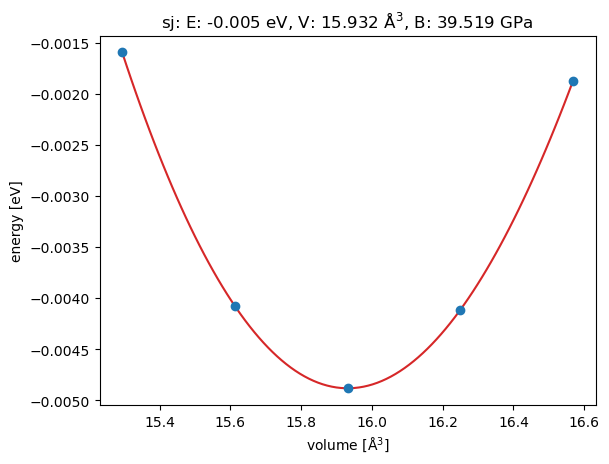

In [7]:
el = "Al"
structure_dict = get_equilibirum_lattice.invoke({"chemical_symbol": el})
plot_equation_of_state.invoke({"atom_dict": structure_dict})

## Agents
Following the same Langchain tutorial for [custom agents](https://python.langchain.com/docs/how_to/custom_tools/) as before a LLM agent is constructed which combines the system prompt, the python functions `get_equilibirum_lattice()` and `plot_equation_of_state()` as tools and the `OpenAIToolsAgentOutputParser()`:

In [8]:
GROQ_API_KEY = getpass(prompt='Enter your Groq Token:')
llm = ChatGroq(model="llama3-70b-8192", temperature=0, groq_api_key=GROQ_API_KEY)
tools = [get_equilibirum_lattice, plot_equation_of_state]
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful assistant, but don't know current events. For each query vailidate that it contains a chemical element and otherwise cancel.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools)
    | OpenAIToolsAgentOutputParser()
)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

Enter your Groq Token: ········


## User Interactions
The user can then interact with the agent by asking it to `Plot the equation of state of gold`. In the background the agent first calls the `get_equilibirum_lattice()` with the parameter `Au` for the chemical symbol of gold and afterwards `plot_equation_of_state()` with the atomistic structure returned by `get_equilibirum_lattice()`. 

In [9]:
lst = list(agent_executor.stream({"input": "Plot the equation of state of gold"}))



> Entering new AgentExecutor chain...

Invoking: `get_equilibirum_lattice` with `{'chemical_symbol': 'Au'}`


       Step     Time          Energy          fmax
LBFGS:    0 07:51:22        0.002606        0.308859
LBFGS:    1 07:51:22        0.000032        0.077808
LBFGS:    2 07:51:22       -0.000135        0.003099
LBFGS:    3 07:51:22       -0.000135        0.000029
LBFGS:    4 07:51:22       -0.000135        0.000000
numbers=[79] positions=[[4.761270571021482e-17, -3.44317321286765e-17, -2.0729599738876008e-16]] cell=[[7.040904860568557e-17, 2.028082809705617, 2.0280828097056176], [2.028082809705617, 1.0384771021574885e-16, 2.0280828097056176], [2.028082809705617, 2.028082809705618, 4.963320342464553e-17]] pbc=[True, True, True]

/var/folders/9p/rztyv06d0xv4h26cyv8nrw3m0000gq/T/ipykernel_2816/2598102435.py:6: FutureWarning: Import UnitCellFilter from ase.filters
  ase_optimizer_obj = LBFGS(UnitCellFilter(atoms))


<tool-use>{"tool_calls":[{"id":"pending","type":"function","function":{"name":"plot_equation_of_state"},"parameters":{"atom_dict":{"numbers":[79],"positions":[[4.761270571021482e-17, -3.44317321286765e-17, -2.0729599738876008e-16]],"cell":[[7.040904860568557e-17, 2.028082809705617, 2.0280828097056176], [2.028082809705617, 1.0384771021574885e-16, 2.0280828097056176], [2.028082809705617, 2.028082809705618, 4.963320342464553e-17]],"pbc":[True, True, True]}}}]}]}

> Finished chain.


## Summary
The important point in this example is, that the order of execution of the Python functions is not defined by the user. Instead the LLM automatically determines that `plot_equation_of_state()` needs an `AtomsDict()` object as input and that `get_equilibirum_lattice()` returns such a `AtomsDict()` object as an output, so it makes sense to call `get_equilibirum_lattice()` first and `plot_equation_of_state()` second. The same principles apply to LLM agents with a larger number of python functions. 

The limiting point at the moment is that the LLMs are web services, so all Python objects have to be converted to `JSON` to be communicated to the LLMs. This restricts the choice of Python objects and requires the development of specialized data classes to construct those interfaces between different Python functions. 